In [15]:
"""
FEniCS tutorial demo program: Incompressible Navier-Stokes equations
for channel flow (Poisseuille) on the unit square using the
Incremental Pressure Correction Scheme (IPCS).

  u' + u . nabla(u)) - div(sigma(u, p)) = f
								 div(u) = 0
"""

from __future__ import print_function
from fenics import *
from mshr import *
import numpy as np
import matplotlib.pyplot as plt

In [16]:
T = 10.0           # final time
num_steps = 50    # number of time steps
dt = T / num_steps # time step size
mu = 1             # kinematic viscosity
rho = 1            # density

In [18]:
# Create mesh
mesh = UnitSquareMesh(16, 16)

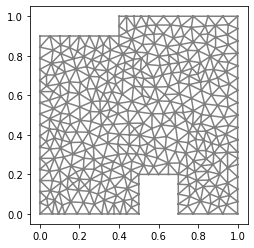

In [27]:
domain = Rectangle(Point(0., 0.), Point(1., 1.)) - \
         Rectangle(dolfin.Point(0.5, 0.0), dolfin.Point(0.7, 0.2)) - \
         Rectangle(dolfin.Point(0.0, 0.9), dolfin.Point(0.4, 1.0)) 

mesh = generate_mesh(domain, 16, "cgal")
plot(mesh)

In [ ]:
# Define function spaces
V = VectorFunctionSpace(mesh, 'P', 2, 2)
Q = FunctionSpace(mesh, 'P', 1)

In [73]:
# Define boundaries
inflow  = 'near(x[0], 0)'
outflow = 'near(x[0], 1)'
walls   = 'near(x[1], 0) || near(x[1], 1)'

# Define boundary conditions
bcu_noslip  = DirichletBC(V, Constant((0, 0)), walls)
bcp_inflow  = DirichletBC(Q, Constant(0), inflow)
bcp_outflow = DirichletBC(Q, Expression('sin(2*pi*x[1])', degree=2), outflow)
bcu = [bcu_noslip]
bcp = [bcp_inflow, bcp_outflow]

In [74]:
# Define trial and test functions
u = TrialFunction(V)
v = TestFunction(V)
p = TrialFunction(Q)
q = TestFunction(Q)

# Define functions for solutions at previous and current time steps
u_n = Function(V)
u_  = Function(V)
p_n = Function(Q)
p_  = Function(Q)

# Define expressions used in variational forms
U   = 0.5*(u_n + u)
n   = FacetNormal(mesh)
f   = Constant((0, 0))
k   = Constant(dt)
mu  = Constant(mu)
rho = Constant(rho)

In [75]:
# Define strain-rate tensor
def epsilon(u):
	return sym(nabla_grad(u))

# Define stress tensor
def sigma(u, p):
	return 2*mu*epsilon(u) - p*Identity(len(u))

In [76]:
# Define variational problem for step 1
F1 = rho*dot((u - u_n) / k, v)*dx + \
     rho*dot(dot(u_n, nabla_grad(u_n)), v)*dx \
     + inner(sigma(U, p_n), epsilon(v))*dx \
     + dot(p_n*n, v)*ds - dot(mu*nabla_grad(U)*n, v)*ds \
     - dot(f, v)*dx
a1 = lhs(F1)
L1 = rhs(F1)

# Define variational problem for step 2
a2 = dot(nabla_grad(p), nabla_grad(q))*dx
L2 = dot(nabla_grad(p_n), nabla_grad(q))*dx - (1/k)*div(u_)*q*dx

# Define variational problem for step 3
a3 = dot(u, v)*dx
L3 = dot(u_, v)*dx - k*dot(nabla_grad(p_ - p_n), v)*dx

In [77]:
# Assemble matrices
A1 = assemble(a1)
A2 = assemble(a2)
A3 = assemble(a3)

# Apply boundary conditions to matrices
[bc.apply(A1) for bc in bcu]
[bc.apply(A2) for bc in bcp]

[None, None]

In [84]:
# Time-stepping
t = 0
for n in range(num_steps):
    t += dt

    # Step 1: Tentative velocity step
    b1 = assemble(L1)
    [bc.apply(b1) for bc in bcu]
    solve(A1, u_.vector(), b1)

    # Step 2: Pressure correction step
    b2 = assemble(L2)
    [bc.apply(b2) for bc in bcp]
    solve(A2, p_.vector(), b2)

    # Step 3: Velocity correction step
    b3 = assemble(L3)
    solve(A3, u_.vector(), b3)

    # Compute error
    u_e = Expression(('4*x[1]*(1.0 - x[1])', '0'), degree=2)
    u_e = interpolate(u_e, V)
    error = np.abs(u_e.vector().get_local() - u_.vector().get_local()).max()
    #print('t = %.2f: error = %.3g' % (t, error))
    #print('max u:', u_.vector().get_local().max())

    # Update previous solution
    u_n.assign(u_)
    p_n.assign(p_)

    
    

In [79]:
print(u_((1,0.7)))

[0.10652808 0.07096549]


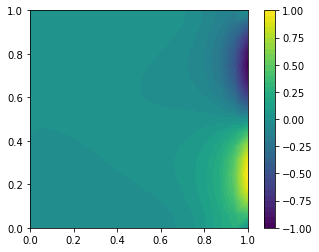

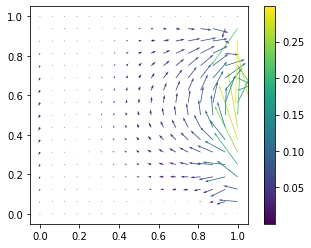

In [80]:
# Plot solution
fig = plot(p_)
plt.colorbar(fig)

plt.show()

fig = plot(u_)
plt.colorbar(fig)

plt.show()